In [341]:
## import
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
pd.options.mode.chained_assignment = None  # default='warn'

In [342]:
## reading in datasets 
df_mask = pd.read_csv('data/mask-use-by-county.csv')
df_votes = pd.read_csv('data/president_county.csv') ## idk if we need
df_results = pd.read_csv('data/president_county_candidate.csv')
df_county = pd.read_csv('data/data.csv', encoding = 'ISO-8859-1')
df_census = pd.read_csv('data/census.csv', encoding = 'ISO-8859-1')
df_covid = pd.read_csv('data/total_covid.csv', names=["date", "county", "state", "fips","total_cases","total_deaths"])

In [343]:
## Fixing the Data ... 

# df_county
df_county = df_county[['fips', 'state_name', 'county_name']]

# df_mask
df_mask = df_mask.rename(columns= {'COUNTYFP':'fips'})
df_mask = df_mask.merge(df_county, left_on='fips', right_on='fips')
df_mask = df_mask[['fips','state_name','county_name','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]
df_mask.columns = ['fips','state','county','never','rarely','sometimes','frequently','always']
df_mask['pos_mask_stat'] = (df_mask['frequently'] + df_mask['always'])/1
df_mask['neg_mask_stat'] = (df_mask['never'] + df_mask['rarely']+ df_mask['sometimes'])/1
df_mask = df_mask[['fips','state','county','pos_mask_stat','neg_mask_stat']]
df_mask['county'] = df_mask['county'].str.lower()
print('Mask Usage Data', df_mask.shape)

# df_votes
# df_results
df_results = df_results.merge(df_votes, left_on=['state', 'county'], right_on=['state', 'county'], suffixes=('_left', '_right') )
df_results = df_results.merge(df_county, left_on=['state', 'county'], right_on=['state_name', 'county_name'])
df_results = df_results[['fips','state_name','county_name','total_votes_left','total_votes_right','won','candidate']]
df_results['percentage'] = df_results['total_votes_left'] / df_results['total_votes_right']
df_results = df_results[['fips','state_name','county_name','total_votes_right','percentage','won','candidate']] 
df_results['won'] = pd.DataFrame(df_results['won']).applymap(str)
df_results = df_results[df_results['won'] == 'True'].reset_index(drop=True)
print('Election Results Data', df_census.shape)

# df_census
df_census = df_census[['CTYNAME','POPESTIMATE2019']]
df_census.columns = ['county','population']
df_census['county'] = df_census['county'].str.lower() 
print('Census Population Data', df_census.shape)

# df_covid
df_covid = df_covid[['county','state','fips','total_cases','total_deaths']]
df_covid = df_covid[df_covid.notna()]
df_covid['fips'] = pd.DataFrame(df_covid['fips']).fillna(0.0).astype(int)
print('Covid Results Data', df_covid.shape)

Mask Usage Data (3143, 5)
Election Results Data (3193, 164)
Census Population Data (3193, 2)
Covid Results Data (3245, 5)


In [344]:
df_merg = df_results.merge(df_mask, left_on='fips', right_on='fips',suffixes=('_left', '_right') )
df_merg = df_merg.merge(df_covid, left_on='fips', right_on='fips',suffixes=('_left', '_right') )
df_merg = df_merg[['fips','county_left','percentage','won','candidate','pos_mask_stat','neg_mask_stat','total_cases','total_deaths']]
df_merg.columns = ['fips','county','percentage','won','candidate','pos_mask_stat','neg_mask_stat','total_cases','total_deaths']
df_merg['death_rate'] = df['total_deaths'] / df['total_cases']
df = df_merg[['fips','percentage','pos_mask_stat','neg_mask_stat','total_cases','total_deaths','death_rate','candidate']]
df = df.drop_duplicates()
df = df.dropna()

print('Cleaned Data', df.shape)

Cleaned Data (3038, 8)


In [345]:
df.head()

,fips,percentage,pos_mask_stat,neg_mask_stat,total_cases,total_deaths,death_rate,candidate
0,10001,0.511945,0.862,0.138,6292,139.0,0.022092,Joe Biden
1,10003,0.678065,0.919,0.081,23576,395.0,0.016754,Joe Biden
2,10005,0.550668,0.959,0.041,11499,269.0,0.023393,Donald Trump
3,11001,0.936662,0.907,0.094,23589,701.0,0.029717,Joe Biden
7,12001,0.629043,0.921,0.078,13567,104.0,0.007666,Joe Biden


In [346]:
df['candidate'] = df['candidate'].str.replace('Donald Trump','0')
df['candidate'] = df['candidate'].str.replace('Joe Biden','1')
df['candidate'] = pd.DataFrame(df['candidate']).applymap(int)

Text(0, 0.5, '% of death')

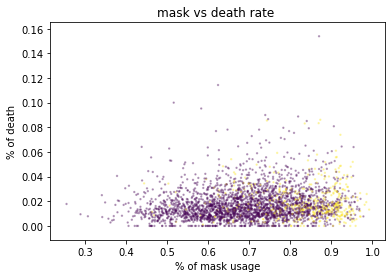

In [347]:
##plotting 
plt.scatter(df['pos_mask_stat'], df['death_rate'], c = df['candidate'], alpha = .3, s=2)

plt.title('mask vs death rate ')
plt.xlabel("% of mask usage")
plt.ylabel('% of death')
#plt.xlim(right=1,left=.4)

In [348]:
# Biden vs. Trump

## getting column for positive response to wearing mask 
df_biden = df[df['candidate'] == 1]
df_trump = df[df['candidate'] == 0]

In [349]:
df_biden.describe()

,fips,percentage,pos_mask_stat,neg_mask_stat,total_cases,total_deaths,death_rate,candidate
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.0
mean,29265.402923,0.606130,0.829353,0.170576,16360.974948,293.286013,0.019566,1.0
std,16469.416852,0.100662,0.099025,0.099039,37067.991230,686.632721,0.013665,0.0
min,1011.000000,0.411369,0.444000,0.009000,24.000000,0.000000,0.000000,1.0
25%,13230.000000,0.535195,0.773500,0.090500,1057.000000,19.000000,0.010561,1.0
50%,28157.000000,0.583199,0.852000,0.148000,4417.000000,62.000000,0.016041,1.0
75%,45014.000000,0.656764,0.909500,0.226500,17208.500000,285.000000,0.026677,1.0
max,56039.000000,1.213873,0.992000,0.555000,466459.000000,8000.000000,0.086111,1.0


In [350]:
df_trump.describe()

,fips,percentage,pos_mask_stat,neg_mask_stat,total_cases,total_deaths,death_rate,candidate
count,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.0
mean,30907.293865,0.723817,0.689661,0.310346,2482.525596,39.247362,0.017337,0.0
std,14746.249720,0.509450,0.123716,0.123722,4448.097283,82.890242,0.013098,0.0
min,1001.000000,0.385929,0.255000,0.022000,1.000000,0.000000,0.000000,0.0
25%,19092.000000,0.628944,0.604000,0.220000,476.000000,6.000000,0.008896,0.0
50%,29221.000000,0.716612,0.695000,0.305000,1105.000000,17.000000,0.014473,0.0
75%,46041.000000,0.784312,0.780000,0.396000,2553.500000,41.000000,0.022624,0.0
max,56045.000000,21.541126,0.978000,0.745000,69024.000000,2089.000000,0.153846,0.0


In [351]:
## obtain X and Y arrays from dataset 
X_biden = np.array(df_biden['pos_mask_stat']).reshape(-1, 1)
y_biden = np.array(df_biden['death_rate']).reshape(-1, 1)

X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
X_biden, y_biden, test_size=0.2, random_state = 1)

regression_biden = linear_model.LinearRegression()

## make regression
regression_biden.fit(X_train_biden, y_train_biden)

##prediction
biden_pred = regression_biden.predict(X_test_biden)

# The coefficients
print('Coefficients: \n', regression_biden.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_biden, biden_pred))
MSE = mean_squared_error(y_test_biden, biden_pred)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_biden, biden_pred))

Coefficients: 
 [[-0.00279215]]
Mean squared error: 0.00
Coefficient of determination: -0.02


Text(0, 0.5, '% of death rate')

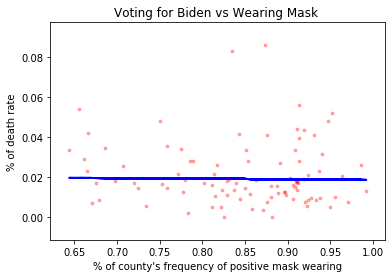

In [352]:
##plotting 
plt.scatter(X_test_biden, y_test_biden, c = 'r', alpha = .3, s=8)
plt.plot(X_test_biden, biden_pred, c = 'b', linewidth=2)
plt.title('Voting for Biden vs Wearing Mask ')
plt.xlabel("% of county's frequency of positive mask wearing")
plt.ylabel('% of death rate')

In [353]:
## summary of linear regression 
X = sm.add_constant(X_biden)
est = sm.OLS(y_biden, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2964
Date:                Wed, 09 Dec 2020   Prob (F-statistic):              0.586
Time:                        03:42:16   Log-Likelihood:                 1377.3
No. Observations:                 479   AIC:                            -2751.
Df Residuals:                     477   BIC:                            -2742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0224      0.005      4.249      0.0

In [355]:
## Cogs109's way of linear regression 
ones = np.ones((479,1))
A_biden = np.hstack((ones, X_biden))

## solve for the weight vector 
w = np.linalg.lstsq(A_biden, y_biden, rcond=None)[0]

print('Linear model: percentage of voting for biden ={first} + {second} * positive mask wearing'.format(first = w[0], second = w[1]))

Linear model: percentage of voting for biden =[0.02241833] + [-0.00343875] * positive mask wearing


In [356]:
## obtain X and Y arrays from dataset 
X_trump = np.array(df_trump['pos_mask_stat']).reshape(-1, 1)
y_trump = np.array(df_trump['death_rate']).reshape(-1, 1)

X_train_trump, X_test_trump, y_train_trump, y_test_trump = train_test_split(
X_trump, y_trump, test_size=0.2, random_state = 1)

regression_trump = linear_model.LinearRegression()

## make regression
regression_trump.fit(X_train_trump, y_train_trump)

##prediction
trump_pred = regression_trump.predict(X_test_trump)

# The coefficients
print('Coefficients: \n', regression_trump.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_trump, trump_pred))
MSE = mean_squared_error(y_test_trump, trump_pred)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_trump, trump_pred))

Coefficients: 
 [[0.01403838]]
Mean squared error: 0.00
Coefficient of determination: 0.04


Text(0, 0.5, '% of death rate')

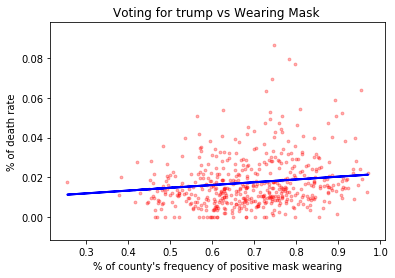

In [357]:
##plotting 
plt.scatter(X_test_trump, y_test_trump, c = 'r', alpha = .3, s=8)
plt.plot(X_test_trump, trump_pred, c = 'b', linewidth=2)
plt.title('Voting for trump vs Wearing Mask ')
plt.xlabel("% of county's frequency of positive mask wearing")
plt.ylabel('% of death rate')

In [358]:
## summary of linear regression 
X = sm.add_constant(X_trump)
est = sm.OLS(y_trump)
est2 = est.fit()
print(est2.summary())

AttributeError: 'NoneType' object has no attribute 'shape'

In [360]:
## Cogs109's way of linear regression 
ones = np.ones((2559,1))
A_trump = np.hstack((ones, X_trump))

## solve for the weight vector 
w = np.linalg.lstsq(A_trump, y_trump, rcond=None)[0]

print('Linear model: percentage of voting for biden ={first} + {second} * positive mask wearing'.format(first = w[0], second = w[1]))

Linear model: percentage of voting for biden =[0.00659059] + [0.01558277] * positive mask wearing


In [367]:
# logistic regression

In [369]:
df_log = df[['percentage','pos_mask_stat','neg_mask_stat','total_cases','total_deaths','death_rate','candidate']]
df_log.head()

,percentage,pos_mask_stat,neg_mask_stat,total_cases,total_deaths,death_rate,candidate
0,0.511945,0.862,0.138,6292,139.0,0.022092,1
1,0.678065,0.919,0.081,23576,395.0,0.016754,1
2,0.550668,0.959,0.041,11499,269.0,0.023393,0
3,0.936662,0.907,0.094,23589,701.0,0.029717,1
7,0.629043,0.921,0.078,13567,104.0,0.007666,1


In [374]:
X_ = np.array([df_log['percentage'], df_log['pos_mask_stat'],df_log['neg_mask_stat'],df_log['total_cases'],df_log['total_deaths'],df_log['death_rate']]).T
y_ = np.array(df_log['candidate']).reshape((-1,))

X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, test_size=0.2, random_state = 10)

model = LogisticRegression()

## make regression
model.fit(X_train, y_train)

##prediction
pred = model.predict(X_test)

##reporting model 
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

## confusion matrix 
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy of logistic regression classifier on test set: 0.87
[[497  11]
 [ 69  31]]


In [375]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       508
           1       0.74      0.31      0.44       100

    accuracy                           0.87       608
   macro avg       0.81      0.64      0.68       608
weighted avg       0.86      0.87      0.85       608



In [361]:
## helper Code

In [ ]:
df_mask1 = df_mask[['county','fips','pos_mask_stat','neg_mask_stat']].dropna()
print(df_mask1.shape)
df_census = df_census.dropna()
print(df_census.shape)

df_mask1['county'] = df_mask1['county'].astype(str)
df_census['county'] = df_census['county'].astype(str)

df_merg = df_mask1.merge(df_census, left_on="county",right_on="county", how='inner')